[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pierchala_et_al_2022/fig_4.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Pierchala_et_al_2022/fig_4.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pierchala_et_al_2022/fig_4.ipynb)

### based on Fig. 4 from Pierchala et al. 2020 (Geochim. Cosmochim. Acta) "_Quantiﬁcation the diﬀusion-induced fractionation of $^{1}H_{2} ^{17}O$ isotopologue in air accompanying the process of water evaporation_" (https://doi.org/10.1016/j.gca.2022.01.020)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import numpy as np
from matplotlib import pyplot
from PySDM import Formulae
from PySDM.physics import in_unit
from open_atmos_jupyter_utils import show_plot

In [3]:
from PySDM_examples.Pierchala_et_al_2022.commons import deltas_0_SMOW, TABLE_1, TABLE_2

formulae = Formulae(
    isotope_equilibrium_fractionation_factors='BarkanAndLuz2005+HoritaAndWesolowski1994',
    isotope_meteoric_water_line='Dansgaard1964+BarkanAndLuz2007',
    isotope_ratio_evolution='RayleighDistillation',
    isotope_kinetic_fractionation_factors='CraigGordon',
)
const = formulae.constants

F = np.linspace(1, .3, 8)

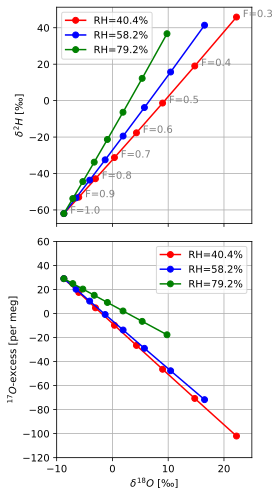

In [4]:
_, axs = pyplot.subplots(2, 1, figsize=(4, 7), sharex=True, tight_layout=True)

deltas_per_rh = {}

for i, RH in enumerate(TABLE_1['Experiment I']['RH']):
    T = TABLE_1['Experiment I']['T'][i]
    color = TABLE_1['Experiment I']['color'][i]
    
    alpha_eq = {}
    deltas_per_rh[RH] = {}
    deltas = deltas_per_rh[RH]    
    for key in ('2H', '18O', '17O'):
        alpha_kin = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic(
            theta = 1,
            turbulence_parameter_n = TABLE_2['n'][key],
            relative_humidity = RH,
            delta_diff = TABLE_2['eps_diff'][key],
        )
        
        alpha_eq[key] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_l_{key}')(
            *((T,) if key != '17O' else (np.nan, alpha_eq['18O']))
        )
        
        deltas[key] = formulae.trivia.isotopic_enrichment_to_delta_SMOW(
            E=formulae.isotope_ratio_evolution.R_over_R0(F, 1 / (alpha_eq[key] * alpha_kin)) - 1,
            delta_0_SMOW=deltas_0_SMOW[key],
        )

    kwargs = {
        'label': f"RH={round(in_unit(RH, const.PER_CENT), 1)}%",
        'color': color,
        'marker': 'o',
    }

    x = in_unit(deltas['18O'], const.PER_MILLE)
    y = in_unit(deltas['2H'], const.PER_MILLE)
    axs[0].plot(
        x,
        y,
        **kwargs
    )
    if i == 0:
        for ixf, f in enumerate(F):
            axs[0].annotate(f"  F={round(f, 1)}", (x[ixf], y[ixf]), color='gray')

    axs[1].plot(
        x,
        in_unit(
            formulae.isotope_meteoric_water_line.excess_17O(deltas['17O'], deltas['18O']),
            const.PER_MEG
        ),
        **kwargs
    )    
    
    for ax in axs:
        ax.set_xlim(-10, 25)
        ax.grid()
        ax.legend()
    axs[1].set_ylim(-120, 60)
        
    axs[0].set_ylabel('$δ^{2}H$ [‰]')
    axs[1].set_ylabel('$^{17}O$-excess [per meg]')
    axs[1].set_xlabel('$δ^{18}O$ [‰]')
    
show_plot("fig_4.pdf")